# Loading Libraries

In [1]:
import pandas as pd
import numpy as np
import re
from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM
from keras.layers import GlobalMaxPooling1D
from keras.models import Model
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.layers import Input
from keras.layers.merge import Concatenate



import matplotlib.pyplot as plt

Using TensorFlow backend.


# Loading Training data

In [2]:
train_data = pd.read_csv('training_data.csv')
train_data.head(15)

,service_name,service_category
0,"Fade, Beard Trim, Line Up",Barber
1,Crochet (bulk hair),Braids
2,Loc Maintenance w/demi color,Natural Hair
3,Buns & Ponytails,Style
4,"Full Leg Wax, Under arms",Waxing
5,"Cut & Blowdry, Womens Cut",Women's Haircut
6,"AHB DOUBLE PROCESS COLOR, AHB CUT",Hair Color
7,"Gel Overlay, Chrome Nails",Manicure
8,"Men's Cut, Arch Wax","Men's Haircut, Eyebrows"
9,"Root Touch Up, Blowout, Hair Glaze Treatment, ...","Hair Color, Style, Hair Treatments, Highlights"


# EDA - 
# Word cloud to visualize the service_category and service_name

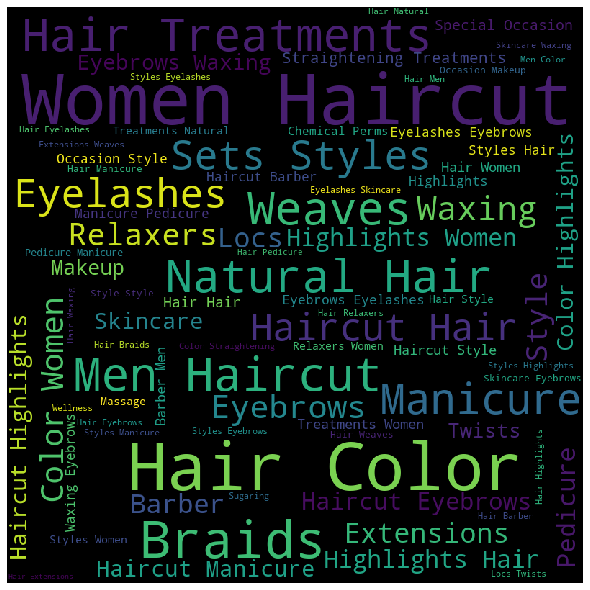

In [3]:
from wordcloud import WordCloud
def plot_word_cloud(text):
    wordcloud_instance = WordCloud(width = 800, height = 800, 
                background_color ='black', 
                stopwords=None,
                min_font_size = 10).generate(text) 
             
    plt.figure(figsize = (8, 8), facecolor = None) 
    plt.imshow(wordcloud_instance) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.show()
        
tags = ''
for index, row in train_data.iterrows():
    tags = tags + ',' + str(row['service_category'])
plot_word_cloud(tags)

In [4]:
from gensim import utils
def clean_text(s):
    s = s.lower()
    s = utils.to_unicode(s)
    for f in filters:
        s = f(s)
    return s

import gensim.parsing.preprocessing as gsp

filters = [
           gsp.strip_tags, 
           gsp.strip_punctuation,
           gsp.strip_multiple_whitespaces,
           gsp.strip_numeric,
           gsp.remove_stopwords, 
           gsp.strip_short, 
           gsp.stem_text
          ]

def plot_word_cloud_of_body_for_tag(tag_name):
    tag_specific_body = ''
    tag_specific_df = train_data[train_data['service_category'].str.contains(tag_name)]

    for index, row in tag_specific_df.iterrows():
        tag_specific_body = tag_specific_body + ' ' + clean_text(row['service_name'])
    
    plot_word_cloud(tag_specific_body)

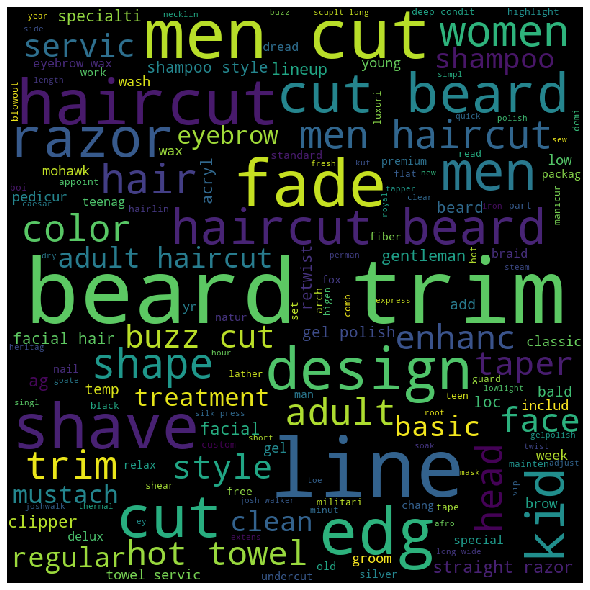

In [5]:
plot_word_cloud_of_body_for_tag('Barber')

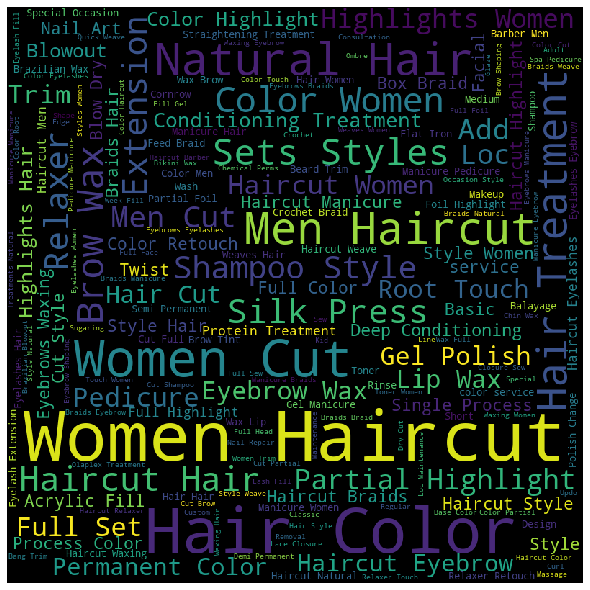

In [6]:
for index, row in train_data.iterrows():
    tags = tags + ',' + str(row['service_name'])
plot_word_cloud(tags)

#  Pre-processing of the data

In [7]:
def remove_spaces(x):
    x=x.split(",")
    nospace=[]
    for item in x:
        item=item.lstrip()
        nospace.append(item)
    return (",").join(nospace)
train_data['service_category']=train_data['service_category'].apply(remove_spaces)
train_data['service_category'] = train_data['service_category'].str.split(",", expand = False)
from sklearn.preprocessing import MultiLabelBinarizer

multilabel_binarizer = MultiLabelBinarizer()
multilabel_binarizer.fit(train_data['service_category'])

# transform target variable
y = multilabel_binarizer.transform(train_data['service_category'])
y

array([[1, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0]])

In [8]:
labels = multilabel_binarizer.classes_
labels

array(['Barber', 'Braids', 'Chemical Perms', 'Curling Treatments',
       'Extensions', 'Eyebrows', 'Eyelashes', 'Hair Color',
       'Hair Treatments', 'Highlights', 'Knots', 'Locs', 'Makeup',
       'Manicure', 'Massage', "Men's Color", "Men's Haircut",
       'Natural Hair', 'Pedicure', 'Relaxers', 'Sets & Styles',
       'Skincare', 'Special Occasion Makeup', 'Special Occasion Style',
       'Straightening Treatments', 'Style', 'Sugaring', 'Twists',
       'Waxing', 'Weaves', 'Wellness', "Women's Haircut"], dtype=object)

In [9]:
for idx, cat in enumerate(multilabel_binarizer.classes_):
    train_data[cat] = y[:,idx]
train_data.head(5)

,service_name,service_category,Barber,Braids,Chemical Perms,Curling Treatments,Extensions,Eyebrows,Eyelashes,Hair Color,...,Special Occasion Makeup,Special Occasion Style,Straightening Treatments,Style,Sugaring,Twists,Waxing,Weaves,Wellness,Women's Haircut
0,"Fade, Beard Trim, Line Up",[Barber],1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Crochet (bulk hair),[Braids],0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Loc Maintenance w/demi color,[Natural Hair],0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Buns & Ponytails,[Style],0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,"Full Leg Wax, Under arms",[Waxing],0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


# Checking Frquency of service_Category

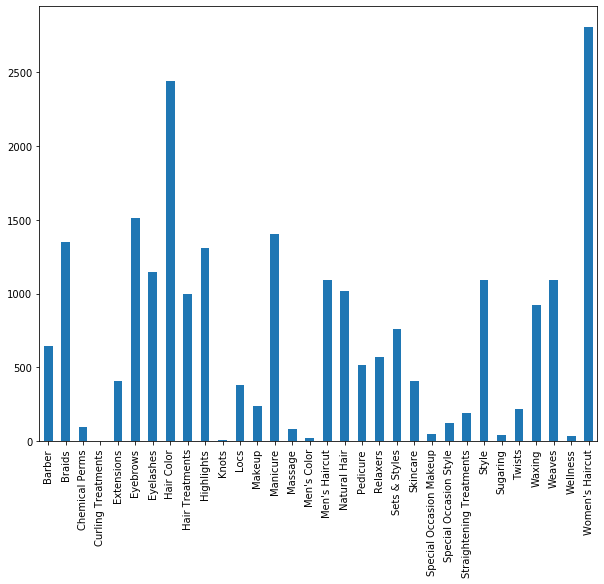

In [10]:
train_data_labels = train_data[['Barber', 'Braids', 'Chemical Perms', 'Curling Treatments',
       'Extensions', 'Eyebrows', 'Eyelashes', 'Hair Color',
       'Hair Treatments', 'Highlights', 'Knots', 'Locs', 'Makeup',
       'Manicure', 'Massage', "Men's Color", "Men's Haircut",
       'Natural Hair', 'Pedicure', 'Relaxers', 'Sets & Styles',
       'Skincare', 'Special Occasion Makeup', 'Special Occasion Style',
       'Straightening Treatments', 'Style', 'Sugaring', 'Twists',
       'Waxing', 'Weaves', 'Wellness', "Women's Haircut"]]
train_data_labels.head()
import matplotlib.pyplot as plt
%matplotlib inline
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 8
plt.rcParams["figure.figsize"] = fig_size

train_data_labels.sum(axis=0).plot.bar()

# handling imabalnce class data - by assigning weights

In [11]:
category = pd.DataFrame(train_data_labels.sum()).reset_index().rename(columns = {'index':'service_category',0:'count'})
category.head()

,service_category,count
0,Barber,642
1,Braids,1352
2,Chemical Perms,96
3,Curling Treatments,3
4,Extensions,411


In [13]:
category['class_weight'] = len(category) / category['count']
class_weight = {}
for index, label in enumerate(labels):
    class_weight[index] = category[category['y'] == label]['class_weight'].values[0]
    
category.head()

,service_category,count,class_weight
0,Barber,642,0.049844
1,Braids,1352,0.023669
2,Chemical Perms,96,0.333333
3,Curling Treatments,3,10.666667
4,Extensions,411,0.077859


In [14]:
category.sort_values('count')

,service_category,count,class_weight
3,Curling Treatments,3,10.666667
10,Knots,9,3.555556
15,Men's Color,24,1.333333
30,Wellness,34,0.941176
26,Sugaring,44,0.727273
22,Special Occasion Makeup,51,0.627451
14,Massage,85,0.376471
2,Chemical Perms,96,0.333333
23,Special Occasion Style,120,0.266667
24,Straightening Treatments,189,0.169312


In [15]:
def get_features(text_series):
    """
    transforms text data to feature_vectors that can be used in the ml model.
    tokenizer must be available.
    """
    sequences = tokenizer.texts_to_sequences(text_series)
    return pad_sequences(sequences, maxlen=maxlen)

In [56]:
train_data.service_name.map(lambda x: len(x)).max()

189


# Implementing Keras

In [60]:
from keras.preprocessing.text import Tokenizer
maxlen = 300
max_words = len(tokenizer.word_index) + 1
tokenizer = Tokenizer(num_words=max_words, lower=True)
tokenizer.fit_on_texts(train_data.service_name)

x = get_features(train_data.service_name)
print(x.shape)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=9000)


(18000, 300)


In [ ]:
from keras.preprocessing.text import Tokenizer
maxlen = 300
max_words = len(tokenizer.word_index) + 1
tokenizer = Tokenizer(num_words=max_words, lower=True)
tokenizer.fit_on_texts(train_data.input_x)
x = get_features(train_data.input_x)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=9000)


In [66]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Embedding, Flatten, GlobalMaxPool1D, Dropout, Conv1D
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from keras.losses import binary_crossentropy
from keras.optimizers import Adam

filter_length = 64
num_classes = 32
model = Sequential()
model.add(Embedding(max_words, 32, input_length=maxlen))
model.add(Dropout(0.1))
model.add(Conv1D(filter_length, 3, padding='valid', activation='relu', strides=1))
model.add(GlobalMaxPool1D())
model.add(Dense(num_classes))
model.add(Activation('sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

callbacks = [
    ReduceLROnPlateau(), 
    EarlyStopping(patience=4), 
    ModelCheckpoint(filepath='model-conv1d1.h5', save_best_only=True)
]

history = model.fit(x_train, y_train,
                    class_weight=class_weight,
                    epochs=100,
                    batch_size=10,
                    validation_split=0.1,
                    callbacks=callbacks)


Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, 300, 32)           123136    
_________________________________________________________________
dropout_13 (Dropout)         (None, 300, 32)           0         
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 298, 64)           6208      
_________________________________________________________________
global_max_pooling1d_13 (Glo (None, 64)                0         
_________________________________________________________________
dense_22 (Dense)             (None, 32)                2080      
_________________________________________________________________
activation_21 (Activation)   (None, 32)                0         
Total params: 131,424
Trainable params: 131,424
Non-trainable params: 0
_______________________________________________

C:\Users\FX253KA\AppData\Local\Continuum\anaconda3\envs\KerasCPU\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 12960 samples, validate on 1440 samples
Epoch 1/100
12960/12960 [==============================] - 7s 571us/step - loss: 0.0076 - accuracy: 0.9576 - val_loss: 0.0051 - val_accuracy: 0.9676
Epoch 2/100
12960/12960 [==============================] - 7s 555us/step - loss: 0.0050 - accuracy: 0.9707 - val_loss: 0.0042 - val_accuracy: 0.9730
Epoch 3/100
12960/12960 [==============================] - 7s 562us/step - loss: 0.0041 - accuracy: 0.9749 - val_loss: 0.0038 - val_accuracy: 0.9756
Epoch 4/100
12960/12960 [==============================] - 8s 597us/step - loss: 0.0036 - accuracy: 0.9771 - val_loss: 0.0034 - val_accuracy: 0.9766
Epoch 5/100
12960/12960 [==============================] - 11s 815us/step - loss: 0.0031 - accuracy: 0.9786 - val_loss: 0.0034 - val_accuracy: 0.9771
Epoch 6/100
12960/12960 [==============================] - 14s 1ms/step - loss: 0.0027 - accuracy: 0.9798 - val_loss: 0.0032 - val_accuracy: 0.9774
Epoch 7/100
12960/12960 [==============================] 

# Model Evaluation

In [108]:
from keras.models import load_model
cnn_model = load_model('model-conv1d1.h5')
metrics = cnn_model.evaluate(x_test, y_test)
print("{}: {}".format(cnn_model.metrics_names[0], metrics[0]))
print("{}: {}".format(cnn_model.metrics_names[1], metrics[1]))

C:\Users\FX253KA\AppData\Local\Continuum\anaconda3\envs\KerasCPU\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


3600/3600 [==============================] - 0s 84us/step
loss: 0.06469549387693405
accuracy: 0.9792795181274414


In [ ]:
from keras.models import load_model
model = load_model('model.h5')
metrics = model.evaluate(x_test, y_test)

# Accuracy plots - Train Vs validation

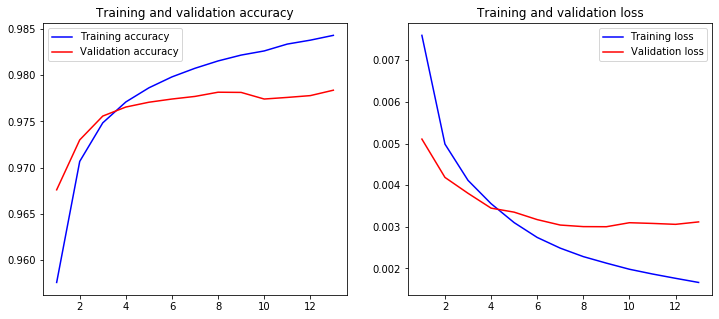

In [109]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training accuracy')
    plt.plot(x, val_acc, 'r', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
plot_history(history)

# Saving model and tokenizer

In [74]:
import pickle
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [75]:
cnn_model = load_model('model-conv1d1.h5')
tokenizer = Tokenizer()
with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

C:\Users\FX253KA\AppData\Local\Continuum\anaconda3\envs\KerasCPU\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [76]:
multilabel_binarizer.classes_

array(['Barber', 'Braids', 'Chemical Perms', 'Curling Treatments',
       'Extensions', 'Eyebrows', 'Eyelashes', 'Hair Color',
       'Hair Treatments', 'Highlights', 'Knots', 'Locs', 'Makeup',
       'Manicure', 'Massage', "Men's Color", "Men's Haircut",
       'Natural Hair', 'Pedicure', 'Relaxers', 'Sets & Styles',
       'Skincare', 'Special Occasion Makeup', 'Special Occasion Style',
       'Straightening Treatments', 'Style', 'Sugaring', 'Twists',
       'Waxing', 'Weaves', 'Wellness', "Women's Haircut"], dtype=object)

In [111]:
labels = np.array(['Barber', 'Braids', 'Chemical Perms', 'Curling Treatments',
       'Extensions', 'Eyebrows', 'Eyelashes', 'Hair Color',
       'Hair Treatments', 'Highlights', 'Knots', 'Locs', 'Makeup',
       'Manicure', 'Massage', "Men's Color", "Men's Haircut",
       'Natural Hair', 'Pedicure', 'Relaxers', 'Sets & Styles',
       'Skincare', 'Special Occasion Makeup', 'Special Occasion Style',
       'Straightening Treatments', 'Style', 'Sugaring', 'Twists',
       'Waxing', 'Weaves', 'Wellness', "Women's Haircut"])
 
predict_data = pd.read_csv('testing_data.csv')
x_predict = get_features(predict_data.service_name)
 
prediction = cnn_model.predict(x_predict)


In [131]:
thresholds=[0.1]
for val in thresholds:
    pred=prediction.copy()
  
    pred[pred>=val]=1
    pred[pred<val]=0

multilabel_binarizer.inverse_transform(pred)
output = pd.DataFrame(pred).to_csv('predicted_output.csv')

# Implementation of Random Forest

Data Preparation

In [59]:
from gensim.models.doc2vec import TaggedDocument, Doc2Vec
from sklearn.base import BaseEstimator
from sklearn import utils as skl_utils
from tqdm import tqdm

import multiprocessing
import numpy as np

class Doc2VecTransformer(BaseEstimator):

    def __init__(self, vector_size=100, learning_rate=0.02, epochs=20, field=None):
        self.learning_rate = learning_rate
        self.epochs = epochs
        self._model = None
        self.vector_size = vector_size
        self.workers = multiprocessing.cpu_count() - 1
        self.field = field

    def fit(self, df_x, df_y=None):
        tagged_x = [TaggedDocument(clean_text(row[str(self.field)]).split(), [index]) for index, row in df_x.iterrows()]
        model = Doc2Vec(documents=tagged_x, vector_size=self.vector_size, workers=self.workers)

        for epoch in range(self.epochs):
            model.train(skl_utils.shuffle([x for x in tqdm(tagged_x)]), total_examples=len(tagged_x), epochs=1)
            model.alpha -= self.learning_rate
            model.min_alpha = model.alpha

        self._model = model
        return self

    def transform(self, df_x):
        return np.asmatrix(np.array([self._model.infer_vector(clean_text(row[str(self.field)]).split())
                                     for index, row in df_x.iterrows()]))

train and validation split

In [60]:
from sklearn.model_selection import train_test_split
train_x, test_x, train_y, test_y = train_test_split(train_data, y)

In [64]:
# from sklearn.pipeline import FeatureUnion
transformer_list=Doc2VecTransformer(field='service_name')

In [65]:

from sklearn.pipeline import Pipeline
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.ensemble import RandomForestClassifier

binary_rel_model = BinaryRelevance(RandomForestClassifier(n_jobs=-1))
multi_label_rf_br_model = Pipeline(steps=[
                           ('transformer_list', transformer_list),
                           ('binary_relevance', binary_rel_model)
                        ])

# Accuracy 

In [66]:
import sklearn.metrics as metrics

def hamming_loss(multi_label_model_pipeline,train_x, train_y, test_x, test_y):
    predictions_test_y = multi_label_model_pipeline.predict(test_x)
    return metrics.hamming_loss(y_true=test_y, y_pred=predictions_test_y)

In [67]:
multi_label_rf_br_model.fit(train_x, train_y)
print('Hamming loss for test data :', hamming_loss(multi_label_rf_br_model,train_x,train_y,test_x,test_y))

100%|███████████████████████████████████████████████████████████████████████| 13500/13500 [00:00<00:00, 4499253.40it/s]


Hamming loss for test data : 0.03892361111111111


In [74]:
Accuracy = (100-(hamming_loss(multi_label_rf_br_model,train_x,train_y,test_x,test_y))*100)
print(f'Accuracy is - {Accuracy}%')

Accuracy is - 96.08958333333334%


# Roc curve plots

In [77]:

from sklearn.metrics import roc_curve, auc

def plot_roc_curve(x=None, y=None, classes=[],title=None):
    
    lw=2
    plt.figure(figsize=(12,6))
    for _class in classes:
        class_index = np.where(multilabel_binarizer.classes_ == _class)[0][0]
        probs = binary_rel_model.classifiers_[class_index].predict_proba(transformer_list.transform(x))[:,1]   
        model_fpr, model_tpr, _ = roc_curve(y[:,class_index], probs)
        roc_auc = auc(model_fpr, model_tpr)
        plt.plot(model_fpr, model_tpr, lw=lw, label='ROC curve -' + _class + '- (area = %0.2f)' % roc_auc)


    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show() 

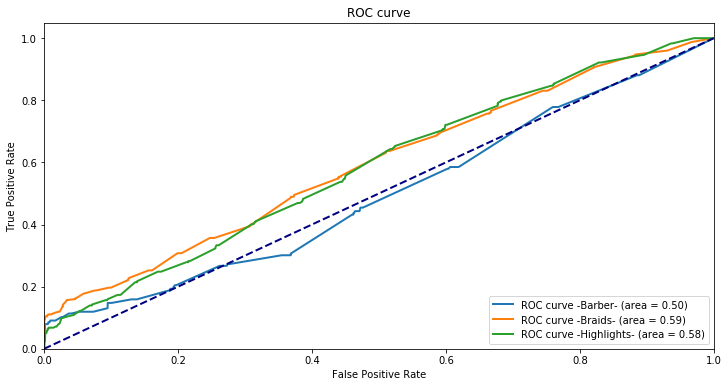

In [79]:
plot_roc_curve(x=test_x, y=test_y, classes=['Barber','Braids','Highlights'], title='ROC curve')